In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

# Load words
words = []
# with open("./data/western_names.txt") as file:
#     words = file.read().splitlines()

with open("./data/indian_names.csv", encoding="utf-8") as file:
    df = pd.read_csv(file, header=None)
    words = df.iloc[:, 0].dropna().tolist()
    words = [w.lower() for w in words if w.isalpha()]
    words = words[1:]
words[0:10]
min(len(w) for w in words)
max(len(w) for w in words)
len("".join(w for w in words)) + len(words)  # total chars from all words +len(words) for the dots

45594

In [57]:
# Initialize character embeddings
unique_chars = sorted(list(set("".join(words))))

char_to_idx = {ch: i + 1 for i, ch in enumerate(unique_chars)}
char_to_idx["."] = 0
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(char_to_idx)
context_size = 3
embed_size = 2


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            idx = char_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [85]:
# Initialize parameters
g = torch.Generator().manual_seed(2147483647)

E = torch.randn((vocab_size, embed_size), generator=g)
W1 = torch.randn((context_size * embed_size, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [E, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [94]:
# training
X = X_train
Y = Y_train

for _ in range(10000):
    # mini-batch
    ix = torch.randint(0, X.size(0), (128,))
    Xb, Yb = X[ix], Y[ix]

    # forward pass
    I = E[Xb].view(-1, context_size * embed_size) # Input layer
    H = torch.tanh(I @ W1 + b1)  # Hidden layer
    L = H @ W2 + b2  # Logit layer
    loss = F.cross_entropy(L, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += 0.1 * -p.grad

print(loss.item())

1.6312671899795532


In [79]:
# loss for validation set
with torch.no_grad():
    I = E[X_val].view(-1, context_size * embed_size) # Input layer
    H = torch.tanh(I @ W1 + b1)  # Hidden layer
    L = H @ W2 + b2  # Logit layer
    loss = F.cross_entropy(L, Y_val)
    print(loss.item())

1.7438029050827026


In [77]:
# loss for test set
with torch.no_grad():
    I = E[X_test].view(-1, context_size * embed_size) # Input layer
    H = torch.tanh(I @ W1 + b1)  # Hidden layer
    L = H @ W2 + b2  # Logit layer
    loss = F.cross_entropy(L, Y_test)
    print(loss.item())

1.7310056686401367


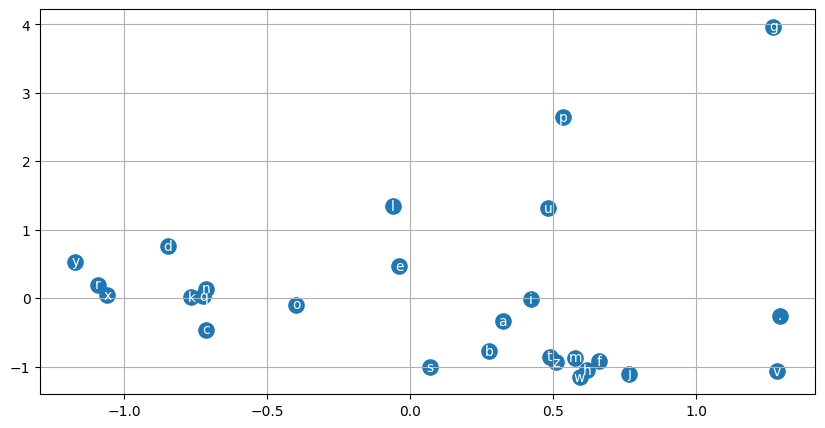

In [98]:
# visualize embedding space
plt.figure(figsize=(10, 5))
plt.scatter(E[:,0].data, E[:,1].data, s=120)
for i in range(E.shape[0]):
    plt.text(E[i,0].item(), E[i,1].item(), idx_to_char[i], ha="center", va="center", color="white")
plt.grid("minor")

In [97]:
# Generate samples
for _ in range(20):
    samples = []
    context = [0] * context_size
    while True:
        I = E[torch.tensor([context])].view(-1, context_size * embed_size)
        H = torch.tanh(I @ W1 + b1)
        logits = H @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        samples.append(idx)
        context = context[1:] + [idx]
        if idx == 0:
            break
    print("Generated samples:", ''.join(idx_to_char[i] for i in samples))

Generated samples: bater.
Generated samples: propil.
Generated samples: bul.
Generated samples: raresh.
Generated samples: rajar.
Generated samples: samekash.
Generated samples: vairmanesh.
Generated samples: ritphender.
Generated samples: sanmil.
Generated samples: sanishnumar.
Generated samples: rah.
Generated samples: sanid.
Generated samples: ulenesh.
Generated samples: din.
Generated samples: dev.
Generated samples: sohu.
Generated samples: sahid.
Generated samples: surenachayan.
Generated samples: sanjeer.
Generated samples: marf.
